In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import (RandomizedSearchCV, train_test_split, StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Function to plot confusion matrix with percentages
def plot_confusion_matrix_with_percentages(y_true, y_pred, title="Confusion Matrix", filename="confusion_matrix.png"):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Percentages of each class
    labels = np.unique(y_true)  # Assumes that the unique labels are the same for both sets

    # Create a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(filename)
    plt.show()

In [3]:
# Define the function for plotting feature importances without numbers
def plot_feature_importance(features_df, title, filename):
    # Normalize the importance values to scale them between 0 and 1 for the gradient
    scaler = MinMaxScaler()
    features_df['Importance_Scaled'] = scaler.fit_transform(features_df[['Importance']])

    # Plot the top 20 features
    plt.figure(figsize=(10, 6))  # Adjust size as needed
    sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')

    # Customize the plot
    plt.title(title, fontsize=18)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(filename, dpi=300)  # Save the plot with high resolution

    # Show the plot
    plt.show()

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/results/Predicciones_Resultados.xlsx
/kaggle/input/paper03data/Python.xlsx
/kaggle/input/predictions-python/XGB pred.xlsx


In [5]:
# Load the dataset
excel_file = '/kaggle/input/paper03data/Python.xlsx'
df = pd.read_excel(excel_file)

# Preview the data
print(df.head())

   f(vij)obj  f(vij)ref  ΔD(drug,assay)1  ΔD(drug,assay)2  ΔD(drug,assay)3  \
0          0   0.695298        45.111861         1.816456         2.309243   
1          0   0.695298        45.451262         1.817035         2.309243   
2          0   0.695298        30.638265         1.817035         2.309243   
3          0   0.695298        45.451262         1.817035         2.309243   
4          0   0.695298        45.111861         1.816456         2.309243   

   ΔV(drug,assay)1  ΔV(drug,assay)2  ΔD(drug,assay)001  ΔD(drug,assay)002  \
0         4.514196         0.031546          22.421064           15.20114   
1         4.514196         0.031546          22.421064           15.20114   
2         4.514196         0.031546          22.421064           15.20114   
3        -4.485804         0.031546          22.421064           15.20114   
4        -4.485804         0.031546          22.421064           15.20114   

   ΔD(drug,assay)003  ...  ΔD(prot,domII,dat)1  ΔD(prot,domII,dat)2 

# Select most relevant features

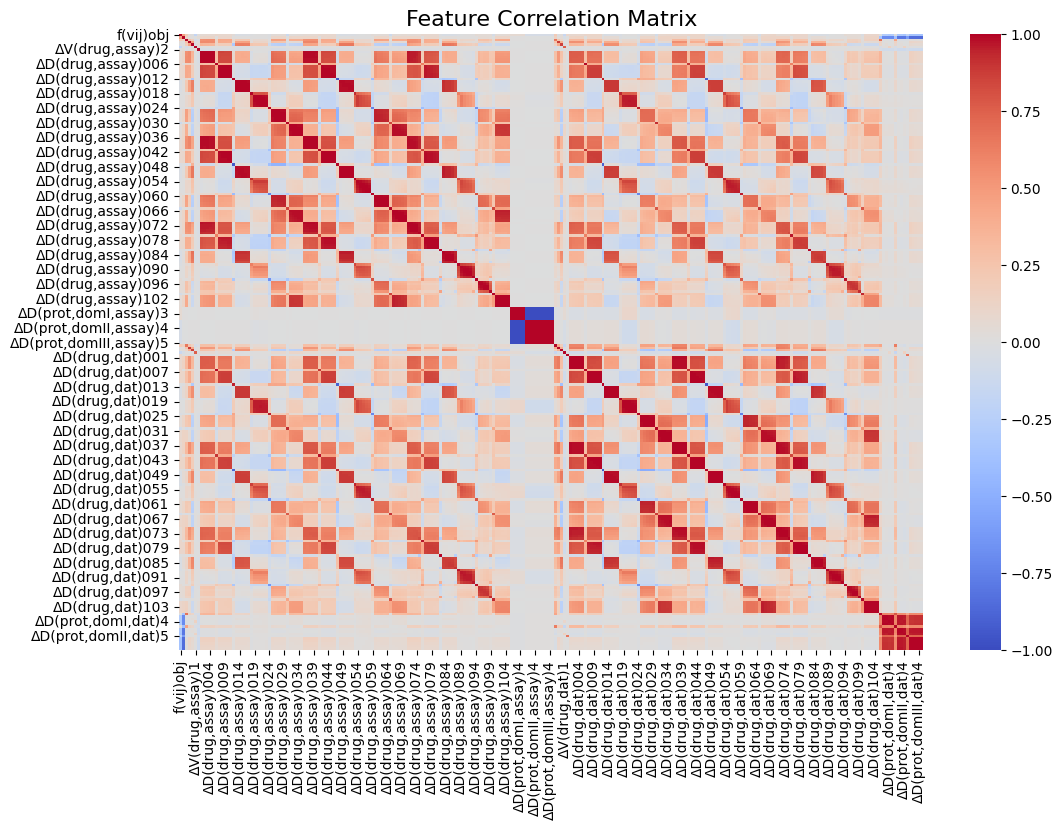

Correlation matrix figure saved at: /kaggle/working/correlation_matrix.png
Features to be removed due to high correlation: {'ΔD(prot,domIII,assay)5', 'ΔD(drug,dat)061', 'ΔD(drug,assay)085', 'ΔD(drug,dat)096', 'ΔD(drug,dat)063', 'ΔD(drug,dat)049', 'ΔD(drug,assay)056', 'ΔD(drug,assay)050', 'ΔD(drug,assay)048', 'ΔD(drug,assay)061', 'ΔD(drug,assay)027', 'ΔD(drug,assay)072', 'ΔD(drug,assay)058', 'ΔD(prot,domI,dat)4', 'ΔD(drug,dat)080', 'ΔD(drug,dat)043', 'ΔD(prot,domIII,dat)5', 'ΔD(drug,dat)021', 'ΔD(drug,assay)075', 'ΔD(drug,assay)004', 'ΔD(drug,dat)006', 'ΔD(prot,domII,dat)4', 'ΔD(drug,dat)015', 'ΔD(drug,dat)069', 'ΔD(drug,dat)014', 'ΔD(drug,assay)104', 'ΔD(drug,assay)077', 'ΔD(drug,assay)015', 'ΔD(drug,dat)050', 'ΔD(drug,assay)078', 'ΔD(drug,dat)075', 'ΔD(drug,dat)037', 'ΔD(prot,domI,assay)2', 'ΔD(drug,dat)077', 'ΔD(drug,assay)052', 'ΔD(drug,dat)068', 'ΔD(drug,dat)004', 'ΔD(drug,assay)040', 'ΔD(drug,assay)102', 'ΔD(drug,assay)062', 'ΔD(drug,assay)064', 'ΔD(drug,dat)048', 'ΔD(drug,dat)085

In [6]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix", fontsize=16)

# Save the figure in high quality
save_path = '/kaggle/working/correlation_matrix.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

# Show the figure
plt.show()

print(f"Correlation matrix figure saved at: {save_path}")

# Set a correlation threshold
threshold = 0.97

# Identify features with high correlation
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.add(correlation_matrix.columns[i])

print(f"Features to be removed due to high correlation: {correlated_features}")

# Drop highly correlated features
df = df.drop(columns=correlated_features)

print(f"Remaining columns after correlation filter: {df.columns}")

# Preview the data
print(df.head())

In [7]:
# Define the variance threshold
var_threshold = 0.01

# Apply variance thresholding
selector = VarianceThreshold(threshold=var_threshold)
df_high_variance = selector.fit_transform(df)

# Get the remaining features
selected_features = df.columns[selector.get_support()]
df = pd.DataFrame(df_high_variance, columns=selected_features)

print(f"Remaining columns after variance filter: {df.columns}")

# Preview the data
print(df.head())

Remaining columns after variance filter: Index(['f(vij)obj', 'f(vij)ref', 'ΔD(drug,assay)1', 'ΔD(drug,assay)2',
       'ΔD(drug,assay)3', 'ΔV(drug,assay)1', 'ΔV(drug,assay)2',
       'ΔD(drug,assay)001', 'ΔD(drug,assay)006', 'ΔD(drug,assay)007',
       'ΔD(drug,assay)013', 'ΔD(drug,assay)018', 'ΔD(drug,assay)019',
       'ΔD(drug,assay)024', 'ΔD(drug,assay)025', 'ΔD(drug,assay)030',
       'ΔD(drug,assay)031', 'ΔD(drug,assay)041', 'ΔD(drug,assay)047',
       'ΔD(drug,assay)053', 'ΔD(drug,assay)054', 'ΔD(drug,assay)059',
       'ΔD(drug,assay)060', 'ΔD(drug,assay)065', 'ΔD(drug,assay)076',
       'ΔD(drug,assay)082', 'ΔD(drug,assay)083', 'ΔD(drug,assay)087',
       'ΔD(drug,assay)088', 'ΔD(drug,assay)089', 'ΔD(drug,assay)093',
       'ΔD(drug,assay)094', 'ΔD(drug,assay)095', 'ΔD(drug,assay)099',
       'ΔD(drug,assay)100', 'ΔD(drug,assay)101', 'ΔD(drug,dat)1',
       'ΔD(drug,dat)2', 'ΔD(drug,dat)3', 'ΔV(drug,dat)1', 'ΔV(drug,dat)2',
       'ΔD(drug,dat)001', 'ΔD(drug,dat)007', 'ΔD(drug

# Define the model

In [8]:
# Define the features and the target
X = df.drop(columns=['f(vij)obj'])
y = df['f(vij)obj']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run all models

In [9]:
# Define the number of folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [10]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
}

In [11]:
# Dictionary to store cross-validation results
model_results = {}

# Evaluate models using K-Fold Cross Validation
for model_name, model in models.items():
    print(f'Evaluating {model_name} with K-Fold...')
    
    accuracy_scores = []
    roc_auc_scores = []

    for train_idx, test_idx in kfold.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_pred = model.predict(X_test_fold)
        y_proba = model.predict_proba(X_test_fold)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Compute metrics
        acc = accuracy_score(y_test_fold, y_pred)
        roc_auc = roc_auc_score(y_test_fold, y_proba) if y_proba is not None else None
        
        accuracy_scores.append(acc)
        if roc_auc is not None:
            roc_auc_scores.append(roc_auc)
    
    # Store the mean metrics
    model_results[model_name] = {
        'Mean Accuracy': np.mean(accuracy_scores),
        'Mean ROC AUC': np.mean(roc_auc_scores) if roc_auc_scores else None
    }

    print(f'{model_name} - Accuracy: {np.mean(accuracy_scores):.2f}, ROC AUC: {np.mean(roc_auc_scores) if roc_auc_scores else "N/A"}')

# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(model_results, orient='index')
print(results_df)

Evaluating Random Forest with K-Fold...
Random Forest - Accuracy: 0.87, ROC AUC: 0.944033698396756
Evaluating SVM with K-Fold...
SVM - Accuracy: 0.76, ROC AUC: 0.8506906812964903
Evaluating Decision Tree with K-Fold...
Decision Tree - Accuracy: 0.85, ROC AUC: 0.8491694933546423
Evaluating KNN with K-Fold...
KNN - Accuracy: 0.80, ROC AUC: 0.878222180800822
Evaluating Gradient Boosting with K-Fold...
Gradient Boosting - Accuracy: 0.85, ROC AUC: 0.9278354027871571
Evaluating XGBoost with K-Fold...
XGBoost - Accuracy: 0.89, ROC AUC: 0.9489949842968091
                   Mean Accuracy  Mean ROC AUC
Random Forest           0.874332      0.944034
SVM                     0.761477      0.850691
Decision Tree           0.850854      0.849169
KNN                     0.804160      0.878222
Gradient Boosting       0.849251      0.927835
XGBoost                 0.885003      0.948995


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


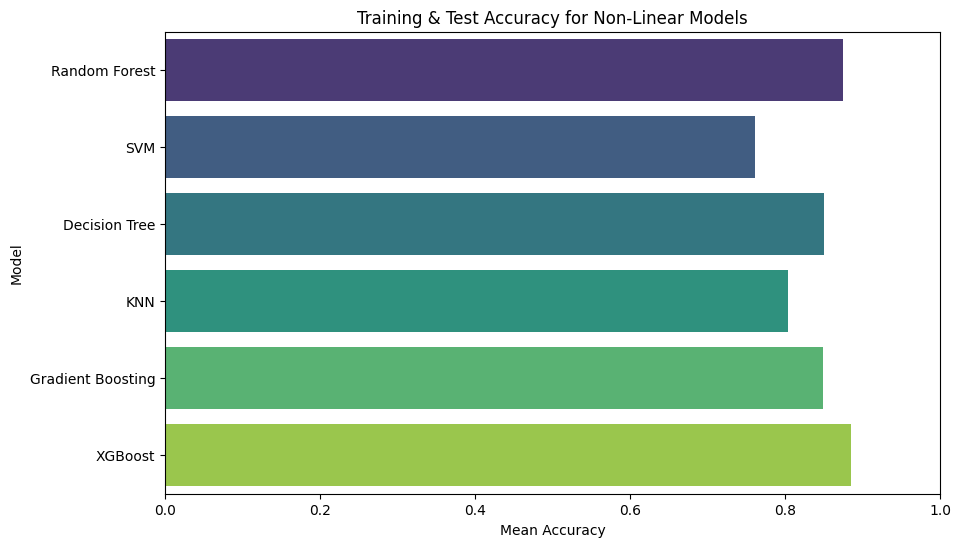

In [12]:
# Exclude LDA from plots
non_linear_models = {name: model for name, model in models.items() if name != 'LDA'}

# Extract model names, accuracy, and ROC AUC scores
model_names = list(non_linear_models.keys())
train_accuracies = [model_results[name]['Mean Accuracy'] for name in model_names]
roc_aucs = [model_results[name]['Mean ROC AUC'] for name in model_names]

# HORIZONTAL BAR PLOT - TRAINING ACCURACY & TEST ACCURACY
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(model_names))

sns.barplot(x=train_accuracies, y=model_names, palette=colors)

plt.xlabel('Mean Accuracy')
plt.ylabel('Model')
plt.title('Training & Test Accuracy for Non-Linear Models')
plt.xlim(0, 1)

# Save the figure
plt.savefig("model_accuracy_barplot.png", dpi=300, bbox_inches="tight")
plt.show()

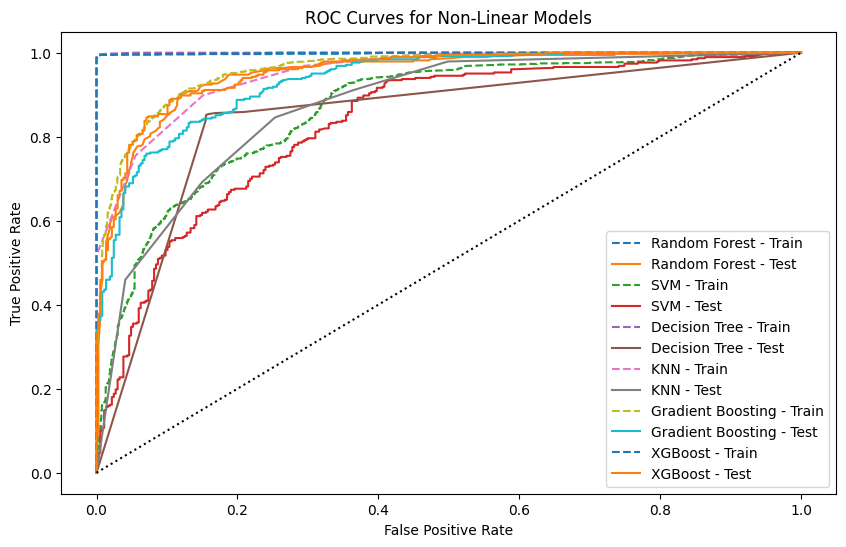

In [13]:
# ROC Curves for Non-Linear Models
non_linear_models = {name: model for name, model in models.items() if name not in ['LDA', 'Logistic Regression']}

plt.figure(figsize=(10, 6))
for model_name, model in non_linear_models.items():
    model.fit(X_train, y_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Compute ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    # Plot
    plt.plot(fpr_train, tpr_train, linestyle='--', label=f'{model_name} - Train')
    plt.plot(fpr_test, tpr_test, label=f'{model_name} - Test')

# Plot Random Classifier line
plt.plot([0, 1], [0, 1], linestyle='dotted', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Non-Linear Models')
plt.legend()

# Save the ROC curve plot
plt.savefig("roc_curves_non_linear_models.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Select the best model based on highest mean accuracy from cross-validation
best_model_name = max(model_results, key=lambda k: model_results[k]['Mean Accuracy'])
best_model = models[best_model_name]

print(f"\nRetraining the best model: {best_model_name} on full training data...")

# Train the best model on the full training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

# Compute final performance metrics
final_accuracy = accuracy_score(y_test, y_test_pred)
final_roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None

# Display final results
print(f"\nFinal Test Set Results for {best_model_name}:")
print(f"Accuracy: {final_accuracy:.2f}")
print(f"ROC AUC: {final_roc_auc:.2f}" if final_roc_auc is not None else "ROC AUC: N/A")


Retraining the best model: XGBoost on full training data...

Final Test Set Results for XGBoost:
Accuracy: 0.89
ROC AUC: 0.95


In [16]:
# Re-define helper to plot confusion matrix with percentages (your original function)
def plot_confusion_matrix_with_percentages(y_true, y_pred, title="Confusion Matrix", filename="confusion_matrix.png"):
    cm = confusion_matrix(y_true, y_pred)
    # handle division by zero if a class has no samples in a row
    with np.errstate(all='ignore'):
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    labels = np.unique(y_true)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Utility: safe predict_proba (if unavailable, use decision_function then scale)
def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        try:
            return model.predict_proba(X)[:, 1]
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        # scale decision_function output to [0,1] with min-max (not ideal but works for ROC)
        df = model.decision_function(X)
        # avoid constant array
        if np.ptp(df) == 0:
            return np.zeros_like(df)
        return (df - df.min()) / (df.max() - df.min())
    # fallback: use predicted labels (will give ROC AUC meaningless but kept)
    return model.predict(X)

In [17]:
# Parameter distributions / grids (simplificados para acelerar)
param_distributions = {
    'Random Forest': {
        'n_estimators': [200, 500],
        'max_depth': [10, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt'],
        'criterion': ['gini', 'entropy']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf'],
        'probability': [True]
    },
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'max_features': ['sqrt']
    },
    'XGBoost': {
        'n_estimators': [200, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 1],
        'reg_alpha': [0, 1],
        'reg_lambda': [1, 2]
    }
}

In [18]:
# Models (instances)
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'SVM': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
}

# Tuner settings
n_iter_search = 10   # menos iteraciones → más rápido
cv_folds = 3         # menos folds → más rápido
scoring = 'roc_auc'    # good for binary; if multiclass, you may change to 'accuracy' or 'roc_auc_ovr'
random_state = 42

skf_inner = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# Container for results
tuned_models = {}
model_results = []

In [19]:
# Run RandomizedSearchCV for each model
for name, base_model in models.items():
    print(f"\nTuning {name} ...")
    param_dist = param_distributions.get(name, None)
    if param_dist is None:
        print(f"No param grid for {name}, skipping tuning.")
        tuned_models[name] = base_model
        continue

    # Use RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=n_iter_search,
        scoring=scoring,
        n_jobs=-1,
        cv=skf_inner,
        verbose=1,
        random_state=random_state,
        return_train_score=False
    )

    search.fit(X_train, y_train)
    best = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_
    print(f"Best {name} params: {best_params}")
    print(f"Best CV {scoring}: {best_score:.4f}")

    tuned_models[name] = best

    # Save the search object for inspection
    joblib.dump(search, f"search_{name.replace(' ', '_')}.pkl")


Tuning Random Forest ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest params: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy'}
Best CV roc_auc: 0.9272

Tuning SVM ...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVM params: {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best CV roc_auc: 0.8771

Tuning Decision Tree ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Decision Tree params: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None, 'criterion': 'gini'}
Best CV roc_auc: 0.8664

Tuning KNN ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best KNN params: {'weights': 'distance', 'p': 1, 'n_neighbors': 7}
Best CV roc_auc: 0.8986

Tuning Gradient Boosting ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Gradient Boosting params: {'subsample': 1.0, 'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.05}
Best CV roc_auc: 0.9309

Tuning XGBoost ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 7,

In [21]:
# Create summary DataFrame
summary_df = pd.DataFrame(model_results).set_index('Model')

# Convert Best_Params dict to JSON string for readability in CSV
summary_df['Best_Params'] = summary_df['Best_Params'].apply(lambda d: json.dumps(d, default=str)[:2000])  # truncate if very long

# Save summary
summary_csv = "model_summary.csv"
summary_df.to_csv(summary_csv)
print(f"\nSummary table saved to {summary_csv}")
display(summary_df)


Summary table saved to model_summary.csv


,Best_Params,Train_Accuracy,Test_Accuracy,F1,Precision,Recall,ROC_AUC
Model,,,,,,,
Random Forest,"{""bootstrap"": true, ""ccp_alpha"": 0.0, ""class_w...",0.946631,0.877333,0.881137,0.872123,0.890339,0.947382
SVM,"{""C"": 10, ""break_ties"": false, ""cache_size"": 2...",0.826885,0.788000,0.808203,0.751121,0.874674,0.864358
Decision Tree,"{""ccp_alpha"": 0.0, ""class_weight"": null, ""crit...",0.929620,0.837333,0.839895,0.844327,0.835509,0.891236
KNN,"{""algorithm"": ""auto"", ""leaf_size"": 30, ""metric...",0.996331,0.833333,0.839125,0.827411,0.851175,0.911971
Gradient Boosting,"{""ccp_alpha"": 0.0, ""criterion"": ""friedman_mse""...",0.995330,0.894667,0.897536,0.891753,0.903394,0.958175
XGBoost,"{""objective"": ""binary:logistic"", ""base_score"":...",0.972982,0.889333,0.891786,0.890625,0.892950,0.958779


In [23]:
# If you want also a classification report:
from sklearn.metrics import classification_report
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_best_pred, digits=4))

# Save the best model
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_')}.pkl")
print(f"Best model saved as best_model_{best_model_name.replace(' ', '_')}.pkl")


Classification Report (Best Model):
              precision    recall  f1-score   support

         0.0     0.8978    0.8856    0.8916       367
         1.0     0.8918    0.9034    0.8975       383

    accuracy                         0.8947       750
   macro avg     0.8948    0.8945    0.8946       750
weighted avg     0.8947    0.8947    0.8946       750

Best model saved as best_model_Gradient_Boosting.pkl


In [24]:
# Print final summary table again
print("\nFINAL SUMMARY:")
print(summary_df)


FINAL SUMMARY:
                                                         Best_Params  \
Model                                                                  
Random Forest      {"bootstrap": true, "ccp_alpha": 0.0, "class_w...   
SVM                {"C": 10, "break_ties": false, "cache_size": 2...   
Decision Tree      {"ccp_alpha": 0.0, "class_weight": null, "crit...   
KNN                {"algorithm": "auto", "leaf_size": 30, "metric...   
Gradient Boosting  {"ccp_alpha": 0.0, "criterion": "friedman_mse"...   
XGBoost            {"objective": "binary:logistic", "base_score":...   

                   Train_Accuracy  Test_Accuracy        F1  Precision  \
Model                                                                   
Random Forest            0.946631       0.877333  0.881137   0.872123   
SVM                      0.826885       0.788000  0.808203   0.751121   
Decision Tree            0.929620       0.837333  0.839895   0.844327   
KNN                      0.996331       0.

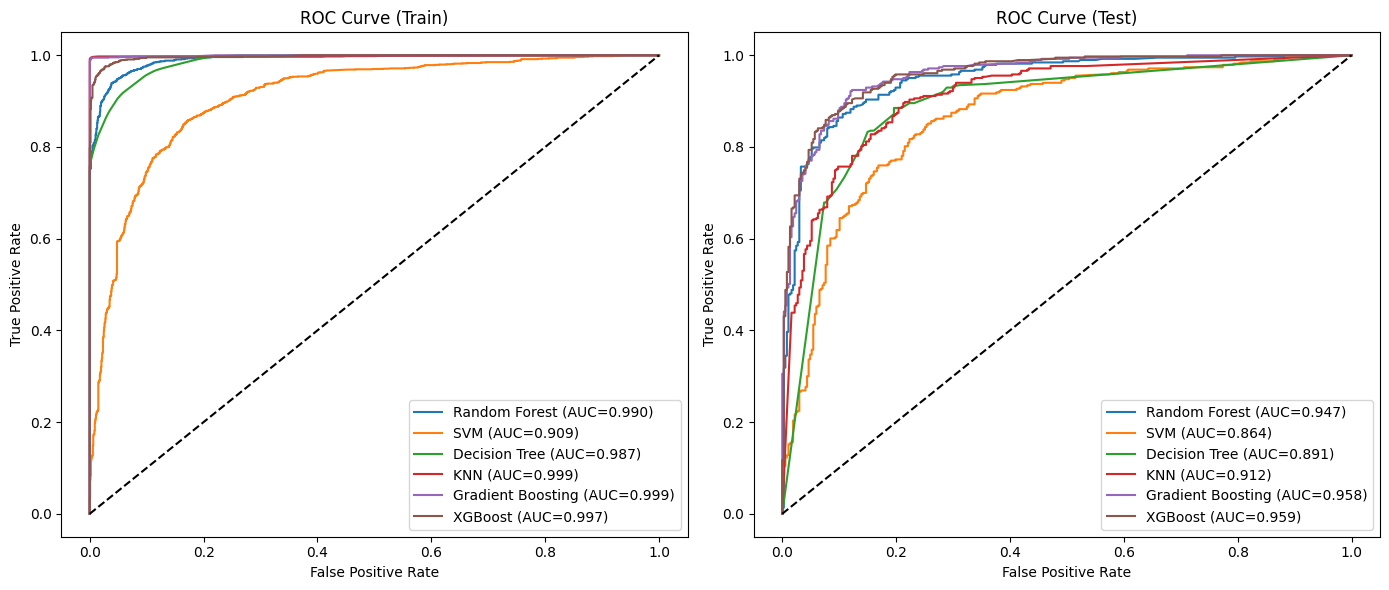

In [26]:
# ========= 1. ROC CURVES =========
def plot_roc_curves(models, X_train, y_train, X_test, y_test, save_path="roc_curves_train_test.png"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ROC curves for train
    for name, model in models.items():
        y_train_proba = model.predict_proba(X_train)[:, 1]
        fpr, tpr, _ = roc_curve(y_train, y_train_proba)
        roc_auc = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_title("ROC Curve (Train)")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend()

    # ROC curves for test
    for name, model in models.items():
        y_test_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_title("ROC Curve (Test)")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_roc_curves(tuned_models, X_train, y_train, X_test, y_test)



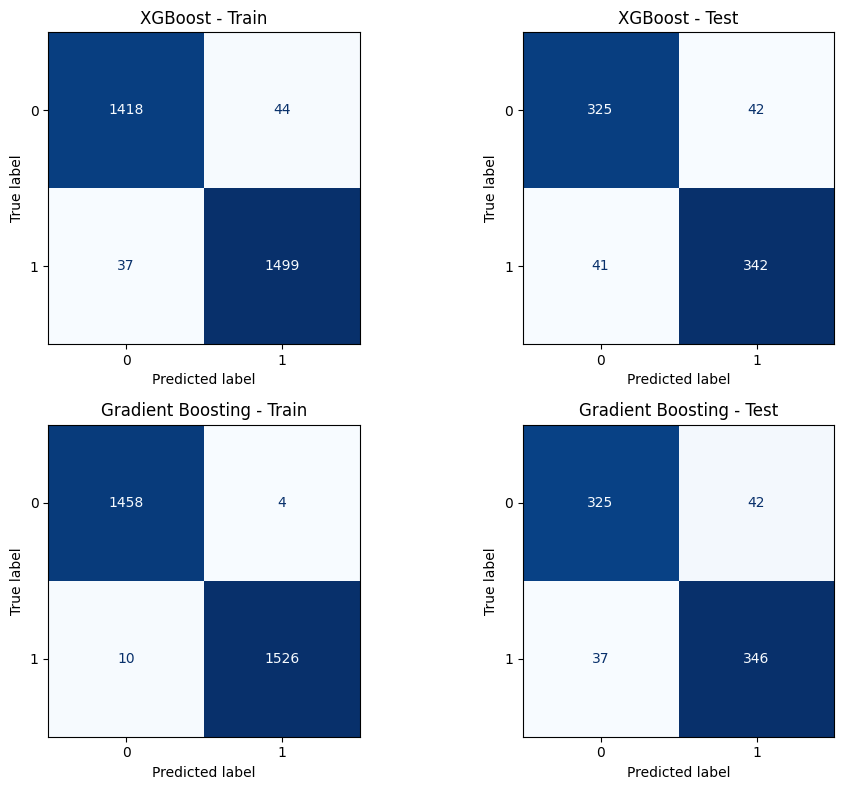

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices_train_test(models, model_names, X_train, y_train, X_test, y_test, save_path="confusion_matrices_train_test.png"):
    fig, axes = plt.subplots(len(model_names), 2, figsize=(10, 8))

    for row, name in enumerate(model_names):
        model = models[name]

        # Train confusion matrix
        y_train_pred = model.predict(X_train)
        cm_train = confusion_matrix(y_train, y_train_pred)
        disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
        disp_train.plot(ax=axes[row, 0], cmap="Blues", colorbar=False)
        axes[row, 0].set_title(f"{name} - Train")

        # Test confusion matrix
        y_test_pred = model.predict(X_test)
        cm_test = confusion_matrix(y_test, y_test_pred)
        disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
        disp_test.plot(ax=axes[row, 1], cmap="Blues", colorbar=False)
        axes[row, 1].set_title(f"{name} - Test")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example usage
plot_confusion_matrices_train_test(
    tuned_models,
    ["XGBoost", "Gradient Boosting"],
    X_train, y_train,
    X_test, y_test
)

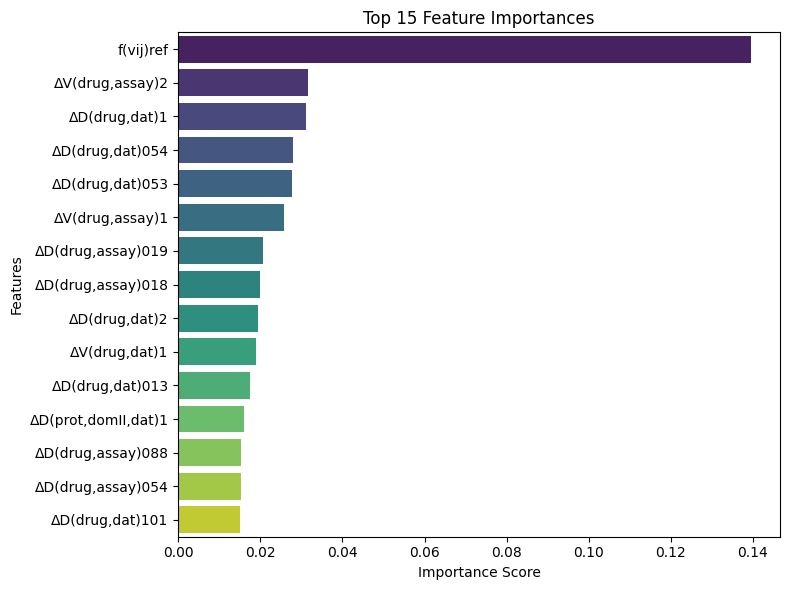

In [28]:
# ========= 3. FEATURE IMPORTANCE (Top 15) =========
def plot_feature_importance(model, feature_names, top_n=15, save_path="xgboost_feature_importance.png"):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1][:top_n]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importance[indices], y=np.array(feature_names)[indices], palette="viridis")
    plt.title(f"Top {top_n} Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example for XGBoost
plot_feature_importance(tuned_models["XGBoost"], X_train.columns, top_n=15)

In [30]:
def feature_importance_table(model, feature_names, top_n=15, save_path="xgboost_feature_importance_table.csv"):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1][:top_n]

    # Create a dataframe
    df_importance = pd.DataFrame({
        "Feature": np.array(feature_names)[indices],
        "Importance": importance[indices]
    })

    # Save table
    df_importance.to_csv(save_path, index=False)

    return df_importance

# Example for XGBoost
fi_table = feature_importance_table(tuned_models["XGBoost"], X_train.columns, top_n=15)

# Show table in Kaggle
fi_table

,Feature,Importance
0,f(vij)ref,0.139607
1,"ΔV(drug,assay)2",0.031705
2,"ΔD(drug,dat)1",0.031037
3,"ΔD(drug,dat)054",0.027837
4,"ΔD(drug,dat)053",0.027795
5,"ΔV(drug,assay)1",0.025808
6,"ΔD(drug,assay)019",0.020706
7,"ΔD(drug,assay)018",0.019927
8,"ΔD(drug,dat)2",0.019332
9,"ΔV(drug,dat)1",0.018881
